In [1]:
# imports 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5_utilities_module as h5u
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
import pingouin as pg
import warnings
from scipy.stats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, alpha*100, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 100 - (alpha*100), axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def arima_preprocess_trials(in_data, arima_params=(10, 2, 2)):
   """
   Apply ARIMA preprocessing to all trials of a time series.
   
   Parameters:
   -----------
   in_data: array [n_trials x n_times] - time series data
   arima_params: tuple - (p, d, q) ARIMA order
   
   Returns:
   --------
   whitened_data: array [n_trials x n_times] - ARIMA residuals or original data
   success_mask: array [n_trials] - boolean mask indicating ARIMA success per trial
   """
   
   n_trials, n_times = in_data.shape
   whitened_data = np.full((n_trials, n_times), np.nan)
   success_mask = np.zeros(n_trials, dtype=bool)
   
   for t in tqdm(range(n_trials)):
       try:
           model = ARIMA(in_data[t, :], order=arima_params)
           fitted = model.fit()
           whitened_data[t, :] = fitted.resid
           success_mask[t] = True
           
       except Exception:
           # Use original data if ARIMA fails
           whitened_data[t, :] = in_data[t, :]
           success_mask[t] = False
   
   return whitened_data, success_mask


def downsample_data(data, original_fs, target_fs, method='decimate', axis=-1, 
                   anti_aliasing=True, ftype='iir'):
    """
    Downsample time series data along specified axis.
    
    Parameters:
    -----------
    data: array - input data (can be multi-dimensional)
    original_fs: int - original sampling frequency in Hz
    target_fs: int - target sampling frequency in Hz
    method: str - downsampling method ('decimate', 'resample', 'mean_pool')
    axis: int - axis along which to downsample (default: -1, last axis)
    anti_aliasing: bool - whether to apply anti-aliasing filter
    ftype: str - filter type for anti-aliasing ('iir' or 'fir')
    
    Returns:
    --------
    downsampled_data: array - downsampled data
    actual_fs: float - actual achieved sampling frequency
    """
    
    if target_fs >= original_fs:
        print(f"Warning: Target fs ({target_fs}) >= original fs ({original_fs}). Returning original data.")
        return data, original_fs
    
    # Calculate downsampling factor
    downsample_factor = original_fs / target_fs
    
    if method == 'decimate':
        # Use scipy.signal.decimate for clean downsampling with anti-aliasing
        if downsample_factor != int(downsample_factor):
            # If not integer factor, use resample instead
            print(f"Non-integer downsample factor ({downsample_factor:.2f}), using resample method")
            method = 'resample'
        else:
            downsample_factor = int(downsample_factor)
            if anti_aliasing:
                downsampled_data = signal.decimate(data, downsample_factor, 
                                                 axis=axis, ftype=ftype)
            else:
                # Simple decimation without filtering
                slices = [slice(None)] * data.ndim
                slices[axis] = slice(None, None, downsample_factor)
                downsampled_data = data[tuple(slices)]
            
            actual_fs = original_fs / downsample_factor
            return downsampled_data, actual_fs
    
    if method == 'resample':
        # Use scipy.signal.resample for arbitrary resampling ratios
        original_length = data.shape[axis]
        target_length = int(original_length * target_fs / original_fs)
        
        downsampled_data = signal.resample(data, target_length, axis=axis)
        actual_fs = target_length * original_fs / original_length
        
        return downsampled_data, actual_fs
    
    elif method == 'mean_pool':
        # Simple mean pooling (fastest but less precise)
        if downsample_factor != int(downsample_factor):
            raise ValueError("mean_pool method requires integer downsample factor")
        
        downsample_factor = int(downsample_factor)
        original_length = data.shape[axis]
        
        # Truncate to make length divisible by downsample_factor
        truncated_length = (original_length // downsample_factor) * downsample_factor
        
        slices = [slice(None)] * data.ndim
        slices[axis] = slice(0, truncated_length)
        truncated_data = data[tuple(slices)]
        
        # Reshape and take mean
        new_shape = list(truncated_data.shape)
        new_shape[axis] = truncated_length // downsample_factor
        new_shape.insert(axis + 1, downsample_factor)
        
        reshaped = truncated_data.reshape(new_shape)
        downsampled_data = np.mean(reshaped, axis=axis + 1)
        
        actual_fs = original_fs / downsample_factor
        return downsampled_data, actual_fs
    
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'decimate', 'resample', 'mean_pool'")


def suggest_target_fs(original_fs, data_length, max_arima_order=50):
    """
    Suggest a reasonable target sampling frequency for ARIMA preprocessing.
    
    Parameters:
    -----------
    original_fs: int - original sampling frequency
    data_length: int - length of time series
    max_arima_order: int - maximum ARIMA order you plan to use
    
    Returns:
    --------
    suggested_fs: int - suggested target sampling frequency
    """
    
    # For neural LFP data, most relevant frequencies are typically < 200 Hz
    # Nyquist theorem suggests we need at least 2x the highest frequency of interest
    
    if original_fs >= 1000:
        # High sampling rate - can downsample significantly
        suggested_fs = 250  # Good for LFP analysis (up to 125 Hz)
    elif original_fs >= 500:
        suggested_fs = 250
    else:
        # Already reasonably low
        suggested_fs = original_fs // 2
    
    # Make sure we don't go too low for the data length and ARIMA order
    min_recommended_fs = max(100, max_arima_order * 2)
    suggested_fs = max(suggested_fs, min_recommended_fs)
    
    return min(suggested_fs, original_fs)


def transmission_analysis(data_A, data_B, lags, time_step, win_size):
    """
    Perform sliding window transmission analysis between two neural time series.

    Tests directional predictive relationships by applying lagged regression analysis
    within sliding temporal windows. Based on the approach described in Crowe et al. 
    (2013) Nature Neuroscience for detecting information transmission between brain areas.

    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
        Neural data from brain area A (e.g., posterior probabilities from decoding).
        Should be preprocessed (e.g., ARIMA whitened) to remove autocorrelation.
    data_B : ndarray, shape (n_trials, n_times)  
        Neural data from brain area B, same format as data_A.
    lags : array_like
        Lag values to test (in time bins). Should start from 0.
        e.g., np.arange(0, 9) tests lags 0-8 bins.
    time_step : float
        Time duration of each bin in milliseconds (e.g., 25.0 for 25ms bins).
    win_size : float  
        Sliding window size in milliseconds (e.g., 500.0 for 500ms windows).
        
    Returns
    -------
    a2b_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area A predicts area B at each lag and time step.
        Higher values indicate stronger predictive relationships.
    b2a_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area B predicts area A at each lag and time step.
    bin_centers : ndarray, shape (n_time_steps,)
        Indices of original time bins corresponding to the center of each sliding window.
        Maps columns in a2b_f/b2a_f back to original data time points. 
    """

    n_samples = int(win_size / time_step)  # Convert to integer
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1  # Number of valid window positions
    
    # Initialize result arrays [n_lags x n_times]
    a2b_f = np.full((len(lags), n_time_steps), np.nan)
    b2a_f = np.full((len(lags), n_time_steps), np.nan)
    
    # Calculate bin centers for each window position
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over valid window positions
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
       
        # Extract windows from all trials
        a_window = data_A[:, window_start:window_end]  # [trials x window_bins]
        b_window = data_B[:, window_start:window_end]  # [trials x window_bins]
       
        for lag_ix, this_lag in enumerate(lags):
           
            # Test A -> B
            if this_lag > 0:
                a_pred = a_window[:, :-this_lag].flatten()  # Earlier A values
                b_targ = b_window[:, this_lag:].flatten()   # Later B values
            else:
                a_pred = a_window.flatten()
                b_targ = b_window.flatten()
               
            # Test B -> A 
            if this_lag > 0:
                b_pred = b_window[:, :-this_lag].flatten()  # Earlier B values
                a_targ = a_window[:, this_lag:].flatten()   # Later A values
            else:
                b_pred = b_window.flatten()
                a_targ = a_window.flatten()
           
            # Run regressions and compute F-statistics
            if len(a_pred) > 10:  # Minimum data check
                try:
                    X = sm.add_constant(a_pred)
                    model = sm.OLS(b_targ, X).fit()
                    a2b_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
                   
            if len(b_pred) > 10:
                try:
                    X = sm.add_constant(b_pred)  
                    model = sm.OLS(a_targ, X).fit()
                    b2a_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
               
    return a2b_f, b2a_f, bin_centers


def spectral_granger_causality_analysis(data_A, data_B, sampling_freq, 
                                       freq_range=None, window_type='hann', 
                                       fft_window_size=None, overlap=0.5):
    """
    Perform spectral Granger causality analysis between two neural time series.
    
    Uses FFT-based spectral estimation to compute frequency-domain Granger causality.
    This approach allows identification of causal relationships at specific frequency bands.
    
    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
        Neural data from brain area A (should be preprocessed).
    data_B : ndarray, shape (n_trials, n_times)
        Neural data from brain area B (should be preprocessed).
    sampling_freq : float
        Sampling frequency in Hz.
    freq_range : tuple or None, optional
        Frequency range to analyze (min_freq, max_freq) in Hz. If None, uses full spectrum.
    window_type : str, optional
        Window function for FFT ('hann', 'hamming', 'blackman'). Default: 'hann'.
    fft_window_size : float or None, optional
        Window size for FFT spectral estimation in seconds. If None, uses entire time series.
    overlap : float, optional
        Overlap between FFT windows (0-1). Default: 0.5.
        
    Returns
    -------
    A_to_B_gc_spectrum : ndarray
        Spectral Granger causality values for A->B at each frequency.
    B_to_A_gc_spectrum : ndarray
        Spectral Granger causality values for B->A at each frequency.
    frequencies : ndarray
        Frequency values corresponding to GC spectrum.
    """
    
    n_trials, n_times = data_A.shape
    
    # Flatten data across trials for analysis
    a_data = data_A.flatten()
    b_data = data_B.flatten()
    
    # Determine window parameters for FFT spectral estimation
    if fft_window_size is None:
        # Use entire time series - no windowing within the data
        nperseg = n_times
        noverlap = 0
    else:
        nperseg = int(fft_window_size * sampling_freq)
        noverlap = int(nperseg * overlap)
    
    # Compute cross-spectral density matrix using Welch's method
    freqs, Sxx = signal.welch(a_data, fs=sampling_freq, window=window_type, 
                              nperseg=nperseg, noverlap=noverlap, 
                              return_onesided=False, scaling='density')
    
    _, Syy = signal.welch(b_data, fs=sampling_freq, window=window_type,
                          nperseg=nperseg, noverlap=noverlap,
                          return_onesided=False, scaling='density')
    
    _, Sxy = signal.csd(a_data, b_data, fs=sampling_freq, window=window_type,
                        nperseg=nperseg, noverlap=noverlap,
                        return_onesided=False, scaling='density')
    
    # Build spectral density matrix
    S = np.zeros((len(freqs), 2, 2), dtype=complex)
    S[:, 0, 0] = Sxx  # S_AA
    S[:, 1, 1] = Syy  # S_BB  
    S[:, 0, 1] = Sxy  # S_AB
    S[:, 1, 0] = np.conj(Sxy)  # S_BA
    
    # Compute spectral Granger causality
    A_to_B_gc_spectrum = np.zeros(len(freqs))
    B_to_A_gc_spectrum = np.zeros(len(freqs))
    
    for f_idx, freq in enumerate(freqs):
        try:
            # Get cross-spectral density matrix at this frequency
            S_f = S[f_idx]
            
            # Compute spectral GC
            gc_B_to_A, gc_A_to_B = _compute_spectral_gc(S_f)
            
            A_to_B_gc_spectrum[f_idx] = gc_A_to_B
            B_to_A_gc_spectrum[f_idx] = gc_B_to_A
            
        except Exception:
            A_to_B_gc_spectrum[f_idx] = np.nan
            B_to_A_gc_spectrum[f_idx] = np.nan
    
    # Filter to requested frequency range
    if freq_range is not None:
        freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        freqs = freqs[freq_mask]
        A_to_B_gc_spectrum = A_to_B_gc_spectrum[freq_mask]
        B_to_A_gc_spectrum = B_to_A_gc_spectrum[freq_mask]
    
    return A_to_B_gc_spectrum, B_to_A_gc_spectrum, freqs


def _compute_spectral_gc(S):
    """
    Compute directional spectral measures from cross-spectral density matrix.
    
    Uses a simplified approach based on partial directed coherence (PDC)
    to approximate spectral Granger causality with directional information.
    
    Parameters
    ----------
    S : ndarray, shape (2, 2)
        Cross-spectral density matrix at a single frequency.
        S[0,0] = S_AA, S[1,1] = S_BB, S[0,1] = S_AB, S[1,0] = S_BA
        
    Returns
    -------
    gc_A_to_B : float
        Spectral causality measure from A (series 1) to B (series 2).
    gc_B_to_A : float
        Spectral causality measure from B (series 2) to A (series 1).
    """
    
    try:
        # Extract spectral components
        S_AA, S_BB = S[0, 0], S[1, 1]  # Keep complex for phase info
        S_AB, S_BA = S[0, 1], S[1, 0]
        
        # Avoid division by zero
        if np.abs(S_AA) <= 1e-10 or np.abs(S_BB) <= 1e-10:
            return np.nan, np.nan
        
        # Compute inverse spectral matrix (approximates transfer function)
        det_S = S_AA * S_BB - S_AB * S_BA
        if np.abs(det_S) <= 1e-10:
            return np.nan, np.nan
            
        # Inverse matrix elements
        H_AA = S_BB / det_S
        H_AB = -S_AB / det_S  
        H_BA = -S_BA / det_S
        H_BB = S_AA / det_S
        
        # Partial directed coherence approximation
        # Standard PDC: PDC_i->j = |H_ji|^2 / sum_k(|H_ki|^2)
        H_col_A_sum = np.abs(H_AA)**2 + np.abs(H_BA)**2  # Column A normalization
        H_col_B_sum = np.abs(H_AB)**2 + np.abs(H_BB)**2  # Column B normalization
        
        if H_col_A_sum <= 1e-10 or H_col_B_sum <= 1e-10:
            return np.nan, np.nan
            
        # PDC calculations (corrected direction assignment)
        pdc_A_to_B = np.abs(H_BA)**2 / H_col_A_sum  # A -> B: H_BA normalized by column A
        pdc_B_to_A = np.abs(H_AB)**2 / H_col_B_sum  # B -> A: H_AB normalized by column B
        
        # Convert to log scale 
        # # Avoid log(0) by adding small epsilon
        # eps = 1e-10
        # gc_A_to_B = pdc_A_to_B / (1 - pdc_A_to_B + eps)
        # gc_B_to_A = pdc_B_to_A / (1 - pdc_B_to_A + eps)

        gc_A_to_B = pdc_A_to_B  # Values between 0 and 1
        gc_B_to_A = pdc_B_to_A
        
        # Additional directional weighting using phase information
        # Use phase lag to enhance directionality
        phase_AB = np.angle(S_AB)
        phase_BA = np.angle(S_BA)
        
        # Phase-based directional modifier (simple heuristic)
        phase_weight_A_to_B = (1 + np.cos(phase_BA)) / 2  # 0 to 1
        phase_weight_B_to_A = (1 + np.cos(phase_AB)) / 2
        
        gc_A_to_B *= phase_weight_A_to_B
        gc_B_to_A *= phase_weight_B_to_A
        
        return float(gc_A_to_B.real), float(gc_B_to_A.real)
        
    except Exception:
        return np.nan, np.nan


    

def shuffle_data(data, axis=1):
    """
    Shuffle data along a specified axis.
    
    Parameters
    ----------
    data : ndarray
        Input data to shuffle
    axis : int, optional
        Axis along which to shuffle. Default is 1.
        - axis=0: Shuffle across trials (rows) - destroys trial structure
        - axis=1: Shuffle across time points (columns) - destroys temporal structure
        
    Returns
    -------
    shuffled_data : ndarray
        Data shuffled along the specified axis
        
    Examples
    --------
    For data with shape (n_trials, n_timepoints):
    
    # Shuffle time points (original behavior)
    shuffled = shuffle_data(data, axis=1)  # Each timepoint shuffled across trials
    
    # Shuffle trials  
    shuffled = shuffle_data(data, axis=0)  # Each trial shuffled across timepoints
    """
    shuffled_data = data.copy()
    
    if axis == 1:
        # Shuffle each time point independently across trials
        # This destroys temporal relationships while preserving marginal distributions
        n_trials, n_timepoints = data.shape
        for t in range(n_timepoints):
            shuffled_data[:, t] = np.random.permutation(data[:, t])
            
    elif axis == 0:
        # Shuffle each trial independently across time points
        # This destroys trial structure while preserving temporal relationships
        n_trials, n_timepoints = data.shape
        for trial in range(n_trials):
            shuffled_data[trial, :] = np.random.permutation(data[trial, :])
            
    else:
        raise ValueError(f"axis must be 0 or 1, got {axis}")
    
    return shuffled_data


def shuffle_data(data, axis=-1):
    """
    Shuffle function that works with any axis and array shape.
    
    Parameters
    ----------
    data : ndarray
        Input data to shuffle
    axis : int, optional  
        Axis along which to shuffle. Default is -1 (last axis).
        
    Returns
    -------
    shuffled_data : ndarray
        Data shuffled along the specified axis
    """
    shuffled_data = data.copy()
    
    # Move the axis to shuffle to the last position
    shuffled_data = np.moveaxis(shuffled_data, axis, -1)
    
    # Get the shape and reshape to 2D for easier processing
    original_shape = shuffled_data.shape
    shuffled_data = shuffled_data.reshape(-1, original_shape[-1])
    
    # Shuffle each row (which corresponds to the moved axis)
    for i in range(shuffled_data.shape[0]):
        shuffled_data[i, :] = np.random.permutation(shuffled_data[i, :])
    
    # Reshape back and move axis back to original position
    shuffled_data = shuffled_data.reshape(original_shape)
    shuffled_data = np.moveaxis(shuffled_data, -1, axis)
    
    return shuffled_data


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


In [3]:
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'
decoder_dir ='C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)
decoder_files = h5u.find_h5_files(decoder_dir)
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder\D20231219_Rec05.h5':
CdN_FR
CdN_channels
CdN_lfp
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_lfp
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
chan_map
lfp_ts
ts


In [4]:
bhv = pd.DataFrame()
all_ofc_lfp = []
all_cdn_lfp = []

for this_file in data_files:

    f_name = Path(this_file).stem
    print(f_name)

    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1

    # load the data
    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    ofc_lfp = np.clip(h5u.pull_from_h5(this_file, 'OFC_lfp'), -1e6, 1e6)
    cdn_lfp = np.clip(h5u.pull_from_h5(this_file, 'CdN_lfp'), -1e6, 1e6)
    lfp_ts = h5u.pull_from_h5(this_file, 'lfp_ts')

    # pull out the channels that have neurons on them
    ofc_unit_channels = np.unique(h5u.pull_from_h5(this_file, 'OFC_channels'))
    cdn_unit_channels = np.unique(h5u.pull_from_h5(this_file, 'CdN_channels'))

    # throw out LFP channels that didn't have neurons
    ofc_lfp = ofc_lfp[:, :, ofc_unit_channels.astype(int)]
    cdn_lfp = cdn_lfp[:, :, cdn_unit_channels.astype(int)]

    # zscore the lfp
    z_ofc_lfp = np.zeros((ofc_lfp.shape[0], len(lfp_ts), ofc_lfp.shape[2]), dtype='float16')
    z_cdn_lfp = np.zeros((ofc_lfp.shape[0], len(lfp_ts), cdn_lfp.shape[2]), dtype='float16')

    print('\nZ-scoring lfps...')
    for ch in tqdm(range(ofc_lfp.shape[2])):

        ofc_ch_mean = np.nanmean(ofc_lfp[:,:, ch])
        ofc_ch_std = np.nanstd(ofc_lfp[:,:, ch])

        z_ofc_lfp[:,:, ch] = (ofc_lfp[:,:, ch] - ofc_ch_mean) / ofc_ch_std

    for ch in tqdm(range(cdn_lfp.shape[2])):
        cdn_ch_mean = np.nanmean(cdn_lfp[:,:, ch])
        cdn_ch_std = np.nanstd(cdn_lfp[:,:, ch])

        z_cdn_lfp[:,:, ch] = (cdn_lfp[:,:, ch] - cdn_ch_mean) / cdn_ch_std

    # delete the original LFP
    del ofc_lfp
    del cdn_lfp

    # now take the mean LFP 
    ofc_mean_lfp = np.nanmean(z_ofc_lfp, axis=2)
    cdn_mean_lfp = np.nanmean(z_cdn_lfp, axis=2)

    # Replace NaN trials with zeros
    ofc_mean_lfp = np.nan_to_num(ofc_mean_lfp, nan=0.0)
    cdn_mean_lfp = np.nan_to_num(cdn_mean_lfp, nan=0.0)

    # now detrend the LFP by subtracting the mean (to remove the evoked component)
    ofc_mean_lfp = ofc_mean_lfp - np.mean(ofc_mean_lfp, axis=0)
    cdn_mean_lfp = cdn_mean_lfp - np.mean(cdn_mean_lfp, axis=0)

    # now aggregate the data
    all_ofc_lfp.append(ofc_mean_lfp)
    all_cdn_lfp.append(cdn_mean_lfp)

# now convert back to arrays
all_ofc_lfp = np.concatenate(all_ofc_lfp, axis=0)
all_cdn_lfp = np.concatenate(all_cdn_lfp, axis=0)


D20231219_Rec05

Z-scoring lfps...


100%|██████████| 256/256 [00:10<00:00, 25.58it/s]


D20231221_Rec06

Z-scoring lfps...


100%|██████████| 222/222 [00:11<00:00, 19.57it/s]


D20231224_Rec07

Z-scoring lfps...


100%|██████████| 178/178 [00:09<00:00, 18.72it/s]


D20231227_Rec08

Z-scoring lfps...


100%|██████████| 184/184 [00:07<00:00, 26.03it/s]


K20240707_Rec06

Z-scoring lfps...


100%|██████████| 246/246 [00:12<00:00, 19.20it/s]


K20240710_Rec07

Z-scoring lfps...


100%|██████████| 258/258 [00:12<00:00, 20.13it/s]


K20240712_Rec08

Z-scoring lfps...


100%|██████████| 115/115 [00:08<00:00, 13.97it/s]


K20240715_Rec09

Z-scoring lfps...


100%|██████████| 106/106 [00:07<00:00, 14.37it/s]


In [ ]:
single_ix = (bhv['n_sacc'] == 1) 
double_ix = (bhv['n_sacc'] == 2) 
d_ix = bhv['fname'].str.contains('D')
k_ix = bhv['fname'].str.contains('K') 

pics_on_ix= np.argmin(np.abs(lfp_ts - 0))
time_before = 100
time_after = 500
freq_range = (2, 50)

# run a test to get the size of the output
d_single_ofc2cdn, s_d_single_cdn2ofc, freqs = spectral_granger_causality_analysis(
    all_ofc_lfp[single_ix & d_ix, pics_on_ix-time_before:pics_on_ix+time_after],
    all_cdn_lfp[single_ix & d_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
    1000,
    freq_range=freq_range, 
    window_type='hann')


In [10]:
# bootstrap confidence intervals
n_bootstrap = 1000

# Pre-allocate bootstrap arrays
d_boot_gc_single = np.zeros((n_bootstrap, len(freqs)))
d_boot_gc_double = np.zeros((n_bootstrap, len(freqs)))
k_boot_gc_single = np.zeros((n_bootstrap, len(freqs)))
k_boot_gc_double = np.zeros((n_bootstrap, len(freqs)))

# Pre-allocate arrays for the null distribution
d_null_gc_single = np.zeros((n_bootstrap, len(freqs)))
d_null_gc_double = np.zeros((n_bootstrap, len(freqs)))
k_null_gc_single = np.zeros((n_bootstrap, len(freqs)))
k_null_gc_double = np.zeros((n_bootstrap, len(freqs)))


print("Running bootstrap analysis...")
for i in tqdm(range(n_bootstrap)):    

    single_trials2use = random_prop_of_array((bhv['state'] < 3) & (bhv['n_sacc'] == 1), .8)
    double_trials2use = random_prop_of_array((bhv['state'] < 3) & (bhv['n_sacc'] == 2), .8)

    # shuffle the data
    s_all_ofc_lfp = shuffle_data(all_ofc_lfp, axis=0)
    
    # NULL DISTRIBUTION GENERATION
    # Single saccade trials
    s_d_single_ofc2cdn, s_d_single_cdn2ofc, _ = spectral_granger_causality_analysis(
        s_all_ofc_lfp[single_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[single_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    s_k_single_ofc2cdn, s_k_single_cdn2ofc, _ = spectral_granger_causality_analysis(
        s_all_ofc_lfp[single_trials2use , pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[single_trials2use , pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    # Double saccade trials 
    s_d_double_ofc2cdn, s_d_double_cn2ofc, _ = spectral_granger_causality_analysis(
        s_all_ofc_lfp[double_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[double_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')

    s_k_double_ofc2cdn, s_k_double_cn2ofc, _ = spectral_granger_causality_analysis(
        s_all_ofc_lfp[double_trials2use , pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[double_trials2use , pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    # Store the directional difference (OFC->CDN minus CDN->OFC)
    d_null_gc_single[i, :] = s_d_single_ofc2cdn - s_d_single_cdn2ofc
    d_null_gc_double[i, :] = s_d_double_ofc2cdn - s_d_double_cn2ofc
    k_null_gc_single[i, :] = s_k_single_ofc2cdn - s_k_single_cdn2ofc
    k_null_gc_double[i, :] = s_k_double_ofc2cdn - s_k_double_cn2ofc


    # BOOTSTRAP FOR CONFIDENCE INTERVAL ESTIMATION
        # Single saccade trials
    s_d_single_ofc2cdn, s_d_single_cdn2ofc, _ = spectral_granger_causality_analysis(
        all_ofc_lfp[single_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[single_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    s_k_single_ofc2cdn, s_k_single_cdn2ofc, _ = spectral_granger_causality_analysis(
        all_ofc_lfp[single_trials2use & k_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[single_trials2use & k_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    # Double saccade trials 
    s_d_double_ofc2cdn, s_d_double_cn2ofc, _ = spectral_granger_causality_analysis(
        all_ofc_lfp[double_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[double_trials2use & d_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')

    s_k_double_ofc2cdn, s_k_double_cn2ofc, _ = spectral_granger_causality_analysis(
        all_ofc_lfp[double_trials2use & k_ix, pics_on_ix-time_before:pics_on_ix+time_after],
        all_cdn_lfp[double_trials2use & k_ix, pics_on_ix-time_before:pics_on_ix+time_after], 
        1000,
        freq_range=freq_range, 
        window_type='hann')
    
    # Store the directional difference (OFC->CDN minus CDN->OFC)
    d_boot_gc_single[i, :] = s_d_single_ofc2cdn - s_d_single_cdn2ofc
    d_boot_gc_double[i, :] = s_d_double_ofc2cdn - s_d_double_cn2ofc
    k_boot_gc_single[i, :] = s_k_single_ofc2cdn - s_k_single_cdn2ofc
    k_boot_gc_double[i, :] = s_k_double_ofc2cdn - s_k_double_cn2ofc

Running bootstrap analysis...


100%|██████████| 1000/1000 [15:22<00:00,  1.08it/s]


In [11]:
# get the bounds of the confidence intervals
d_single_mean, d_single_ci = calculate_mean_and_interval(d_boot_gc_single, 'percentile', alpha = .001)
d_double_mean, d_double_ci = calculate_mean_and_interval(d_boot_gc_double, 'percentile', alpha = .001)
k_single_mean, k_single_ci = calculate_mean_and_interval(k_boot_gc_single, 'percentile', alpha = .001)
k_double_mean, k_double_ci = calculate_mean_and_interval(k_boot_gc_double, 'percentile', alpha = .001)

# get the bounds of the null distributions
d_single_null_mean, d_single_null_ci = calculate_mean_and_interval(d_null_gc_single, 'percentile', alpha = .001)
d_double_null_mean, d_double_null_ci = calculate_mean_and_interval(d_null_gc_double, 'percentile', alpha = .001)
k_single_null_mean, k_single_null_ci = calculate_mean_and_interval(k_null_gc_single, 'percentile', alpha = .001)
k_double_null_mean, k_double_null_ci = calculate_mean_and_interval(k_null_gc_double, 'percentile', alpha = .001)


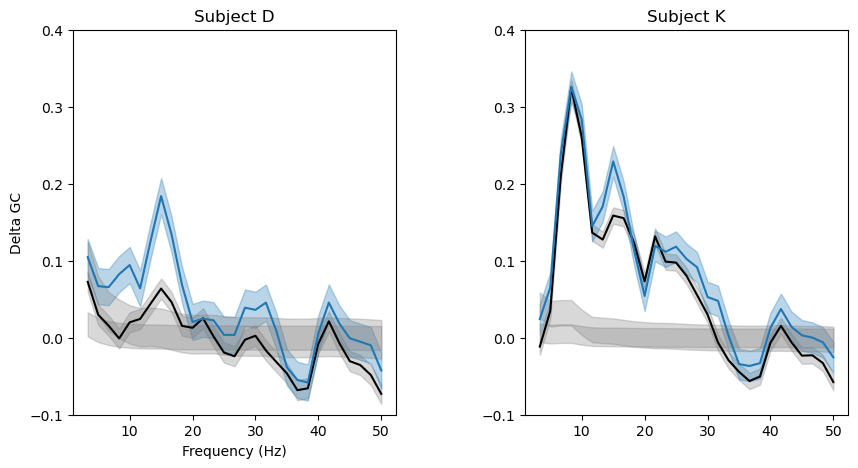

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ax[0].fill_between(freqs, d_single_mean - d_single_ci, d_single_mean + d_single_ci, color='tab:gray', alpha = .3)
ax[0].fill_between(freqs, d_double_mean - d_double_ci, d_double_mean + d_double_ci, color='tab:blue', alpha = .3)
ax[0].plot(freqs, d_single_mean, color = 'black')
ax[0].plot(freqs, d_double_mean, color = 'tab:blue')
ax[0].fill_between(freqs, d_single_null_mean - d_single_null_ci, d_single_null_mean + d_single_null_ci, color='tab:gray', alpha = .3)
ax[0].fill_between(freqs, d_double_null_mean - d_double_null_ci, d_double_null_mean + d_double_null_ci, color='tab:gray', alpha = .3)
ax[0].set_ylim((-.1,.4))
ax[0].set_ylabel('Delta GC')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_title('Subject D')



ax[1].fill_between(freqs, k_single_mean - k_single_ci, k_single_mean + k_single_ci, color='tab:gray', alpha = .3)
ax[1].fill_between(freqs, k_double_mean - k_double_ci, k_double_mean + k_double_ci, color='tab:blue', alpha = .3)
ax[1].plot(freqs, k_single_mean, color = 'black')
ax[1].plot(freqs, k_double_mean, color = 'tab:blue')
ax[1].fill_between(freqs, k_single_null_mean - k_single_null_ci, k_single_null_mean + k_single_null_ci, color='tab:gray', alpha = .3)
ax[1].fill_between(freqs, k_double_null_mean - k_double_null_ci, k_double_null_mean + k_double_null_ci, color='tab:gray', alpha = .3)
ax[1].set_ylim((-.1,.4))
ax[1].set_title('Subject K')

#fig.savefig('Granger_causality.svg')